# Case study on customers' annual spending amounts
## Unsupervised Learning
## Project: Consumer Segmentation

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository]

In [1]:
## Importing the libraries
## Importing data handling libraries
import pandas as pd 
import numpy as np
from collections import OrderedDict

## Importing data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Importing statistical libraries
import scipy.stats as scipy_stats

## Ignoring warnings
import warnings 
warnings.filterwarnings('ignore')

## Model building algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgboost
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_squared_error

## Clustering
from sklearn.cluster import KMeans

## Model Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Learning Curve
from sklearn.model_selection import learning_curve

In [2]:
## Importing the dataset
df = pd.read_csv("customers.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
## Analysing the data
df_copy = df.copy()
df_copy.drop(['Channel'],axis=1,inplace=True)
df_copy.drop(['Region'],axis=1,inplace=True)
df_copy.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [4]:
## Analysing the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicatessen        440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [5]:
# Display a description of the dataset
def custom_summary(df):
    result = []

    for col in list(df.columns):
        stats = OrderedDict({'FeatureName': col,'count':df[col].count(),'Datatype':df[col].dtype,
                                 'Mean':round(df[col].mean(),2),'SD':round(df[col].std(),2),'Variance':round(df[col].var(),2),
                                 'Min':round(df[col].min(),2),'Q1':round(df[col].quantile(0.25),2),'Median':round(df[col].median(),2),
                                 'Q3':round(df[col].quantile(0.75),2),'Max':round(df[col].max(),2),'Range':round(df[col].quantile(1),2)-round(df[col].quantile(0),2),
                                  'IQR':round(df[col].quantile(0.75),2)-round(df[col].quantile(0.25),2),
                                 'Kurtosis':round(df[col].kurt(),2),'Skewness':round(df[col].skew(),2)})
        result.append(stats)
        if df[col].skew() < -1:
            sk_label = 'Highly Negatively Skewed'
        elif -1 <= df[col].skew() < -0.5:
            sk_label = 'Moderately Negatively skewed'
        elif -0.5 <= df[col].skew() < 0:
            sk_label = 'Fairly Symmetric(Negative)'  
        elif 0 <= df[col].skew() < 0.5:
            sk_label = 'Fairly Symmetric(Positive)'
        elif 0.5 <= df[col].skew() < 1:
            sk_label = 'Moderately Positively skewed'
        elif df[col].skew() > 1:
            sk_label = 'Highly Positively Skewed'
        else:
            sk_label = 'Error'        
        stats['Skewness Comment'] = sk_label
        Upper_limit = stats['Q3'] + (1.5 *stats['IQR'])
        Lower_limit = stats['Q1'] - (1.5 *stats['IQR'])
        if len([x for x in df[col] if x < Lower_limit or x > Upper_limit ]) > 1:
            Out_Label = 'Has Outlier'
        else:
            Out_Label = 'No Outlier'
        stats['Outlier comment'] = Out_Label
    resultdf = pd.DataFrame(data = result)
    return resultdf 

In [6]:
custom_summary(df_copy)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,440,int64,12000.30,12647.33,1.599549e+08,3,3127.75,8504.0,16933.75,112151,112148.0,13806.00,11.54,2.56,Highly Positively Skewed,Has Outlier
1,Milk,440,int64,5796.27,7380.38,5.446997e+07,55,1533.00,3627.0,7190.25,73498,73443.0,5657.25,24.67,4.05,Highly Positively Skewed,Has Outlier
2,Grocery,440,int64,7951.28,9503.16,9.031010e+07,3,2153.00,4755.5,10655.75,92780,92777.0,8502.75,20.91,3.59,Highly Positively Skewed,Has Outlier
3,Frozen,440,int64,3071.93,4854.67,2.356785e+07,25,742.25,1526.0,3554.25,60869,60844.0,2812.00,54.69,5.91,Highly Positively Skewed,Has Outlier
4,Detergents_Paper,440,int64,2881.49,4767.85,2.273244e+07,3,256.75,816.5,3922.00,40827,40824.0,3665.25,19.01,3.63,Highly Positively Skewed,Has Outlier
5,Delicatessen,440,int64,1524.87,2820.11,7.952998e+06,3,408.25,965.5,1820.25,47943,47940.0,1412.00,170.69,11.15,Highly Positively Skewed,Has Outlier


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [7]:
# Select three indices of your choice you wish to sample from the dataset
#df_sample = df[["Fresh","Milk","Grocery"]]
#df_sample.head()

# Create a DataFrame of the chosen samples
#df_sample=pd.DataFrame(df_sample)
#df_sample.mean()

In [8]:
# Select three indices of your choice you wish to sample from the dataset
sample = df_copy.sample(n=3, random_state=60)


# Create a DataFrame of the chosen samples
pd.DataFrame(sample)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
193,180,3485,20292,959,5618,666
39,56159,555,902,10002,212,2916
262,23257,1372,1677,982,429,655


In [9]:
sample.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,26532.000000,1804.000000,7623.666667,3981.000000,2086.333333,1412.333333
std,28132.833647,1512.016204,10977.939622,5214.351638,3060.436951,1302.225147
min,180.000000,555.000000,902.000000,959.000000,212.000000,655.000000
25%,11718.500000,963.500000,1289.500000,970.500000,320.500000,660.500000
50%,23257.000000,1372.000000,1677.000000,982.000000,429.000000,666.000000
75%,39708.000000,2428.500000,10984.500000,5492.000000,3023.500000,1791.000000
max,56159.000000,3485.000000,20292.000000,10002.000000,5618.000000,2916.000000


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 3071.9
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


In [10]:
##By comparing the reference values provided above with the actual mean of the data for the 
##3 chosen variables in the data,i.e. "Fresh","Milk and "Grocery
print("The reference means in comparison with the actual mean is shown below")
print("Reference Mean values")
print("---------------------")
print("Fresh:      12000.2977")
print("Milk:        5796.2")
print("Grocery:     3071.9")
print("Actual mean values")
print("--------------")
print(sample)

The reference means in comparison with the actual mean is shown below
Reference Mean values
---------------------
Fresh:      12000.2977
Milk:        5796.2
Grocery:     3071.9
Actual mean values
--------------
     Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
193    180  3485    20292     959              5618           666
39   56159   555      902   10002               212          2916
262  23257  1372     1677     982               429           655


In [11]:
## By looking at sample 1 , it can be observed that the quantity of "Fresh" and "Milk" way less than the average
## but the "Grocery" category have higher spendings than the average. This seems like a Grocery Shop's Estblishment
## By looking at the sample 2, it can be observed that the quantity of spendings on a "Fresh" category is way more than the average
## and also the "Milk" and "Grocery" spendings seems way below the average mark. This seems like a "Fresh veggies vendor" establishment to me.
## By looking at the sample 3, it can be observed that the quantity of spendings on "Fresh" is more than the average value,but the 
## whereas 'Milk' and "Grocery" expenditure is also less than average. This seems like a "medium sized restaurant" Establishment to me.


### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [12]:
for col in df_copy.columns:
    new_data = df_copy.drop([col],axis=1)
    y=pd.DataFrame(df_copy.loc[:,col])
    x_train,x_test,y_train,y_test = train_test_split(new_data,y,test_size=0.30,random_state=100)
    dt = DecisionTreeRegressor()
    dt.fit(x_train,y_train)
    score = dt.score(x_test,y_test)
    print("R2 score for {} as dependent variable: {}".format(col,score))

R2 score for Fresh as dependent variable: -0.31754404818890625
R2 score for Milk as dependent variable: -0.06979656140700508
R2 score for Grocery as dependent variable: 0.7055808321315462
R2 score for Frozen as dependent variable: -0.2046159479610412
R2 score for Detergents_Paper as dependent variable: 0.7038978195900687
R2 score for Delicatessen as dependent variable: -4.979734153338821


In [13]:
new_data = df_copy.copy()
new_data=pd.DataFrame(new_data)
x = new_data.drop(['Fresh'],axis=1)
y = new_data['Fresh']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state = 1)

In [14]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)
ypredtree = dt.predict(x_test)
from sklearn.metrics import accuracy_score,r2_score
#accuracy_score(y,ypredtree)
r2_score(ypredtree,y_test)

-0.2607232186764501

### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

In [15]:
## I carried out this trial on the all by all predicting all the three features.
## When I was predicting the "Fresh" category, the R2 score came to be (-0.4485)
## When I was predicting the "Milk" category, the R2 score came to be( 0.2766)
## When I was predicting the "grocery" category, the R2 score came to be (0.7549)
## When I was predicting the "Frozen" category, the R2 SCORE came to be (-0.3826)
## When I was predicting the "Detergents_Paper" category, the R2 score came to be (0.7092)
## When I was predicting the "Detergents_Paper" category, the R2 score came to be (0.8102408)
## When I was predicting the "Delicatessen" category, the R2 score came to be (9.8718194)
## From the above mentioned scores, we can conclude that "Frozen" and "Fresh" categories are giving negative
## R2-error implying these two categories are not being able to fit into the model thereby implying that 
## these two features are hard to predict using the other features, thereby making "Fresh" and "Frozen" as an 
## important feature to consider.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

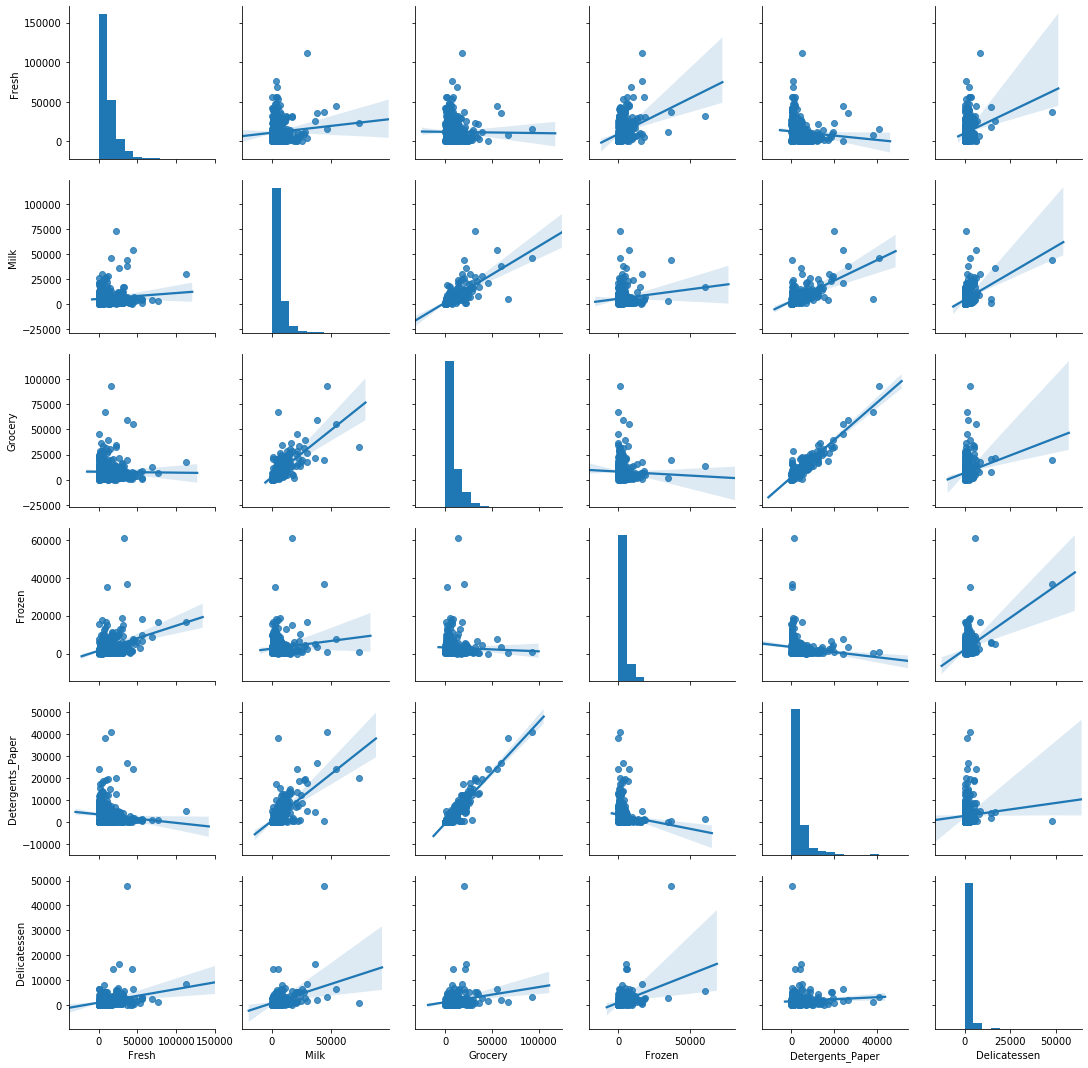

In [16]:
# Produce a scatter matrix for each pair of features in the data
#df_scatter = df.drop('Channel',axis=1)
#df_scatter = df_scatter.drop('Region',axis=1)
sns.pairplot(df_copy,kind='reg') # reg = regression plots

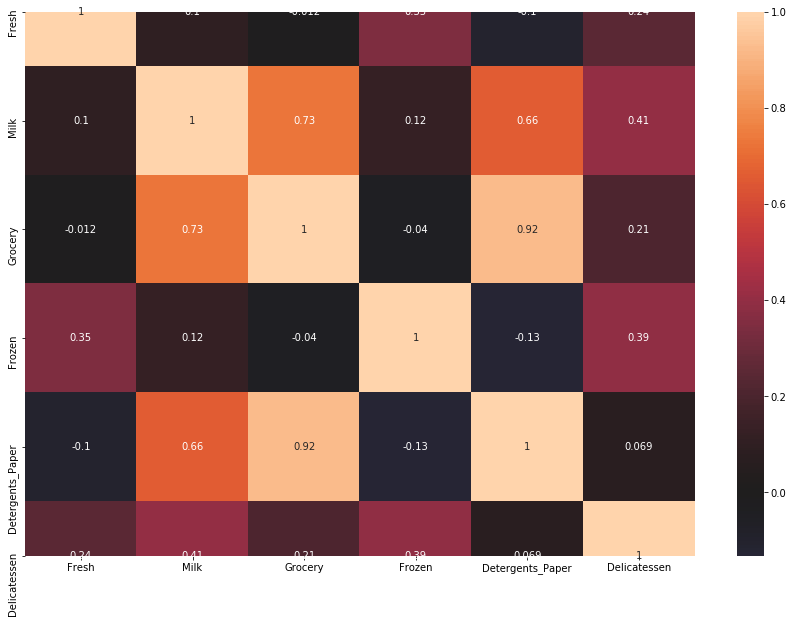

In [17]:
corr_matrix= df_copy.corr()
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix,center = 0,annot=True)

In [18]:
## In the correlation heat map above, it can be seen that "Fresh" and "Frozen" category have all the features in
## low correlation coefficients, There is a very high correlation in the other features but the Fresh and 
## Frozen categories have low correlation coefficients when compared to all the features.
## This also proves that multicolinearity is present between the features and hence PCA must be performed on the dataset.

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Hint:** Is the data normally distributed? Where do most of the data points lie? You can use [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to get the feature correlations and then visualize them using a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html) (the data that would be fed into the heatmap would be the correlation values, for eg: `data.corr()`) to gain further insight.

In [19]:
## In the scatter plot above, we can see that most of the features is positive skewed and features like "Frozen" and "Delicatessen"
## have most of their data points near zero.
## There are some features that display some degree of correlation.
## Milk has a positive correlation with Grocery
## Milk has a positive correlation with Detergents_paper
## Gocery has very high correlation with Detergents_paper
## I tried to predict the Fresh category feature from the dataset but the negative R2 score aand the correlation matrix heat map shows that
## it has low correlation with the other features and is also more unpredictable and relevant

(array([267., 109.,  38.,  16.,   4.,   3.,   2.,   0.,   0.,   1.]),
 array([3.000000e+00, 1.121780e+04, 2.243260e+04, 3.364740e+04,
        4.486220e+04, 5.607700e+04, 6.729180e+04, 7.850660e+04,
        8.972140e+04, 1.009362e+05, 1.121510e+05]),
 <a list of 10 Patch objects>)

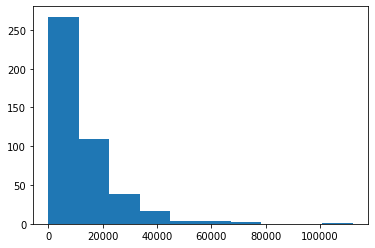

In [20]:
## The data for the Fresh feature is distributed as a highly skewed data and outliers are present in the data.
## Most establishments spend within 20000 as per the histogram below.
plt.hist(df["Fresh"])

In [21]:
df_before_outliers = df_copy.copy()
custom_summary(df_copy)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,440,int64,12000.30,12647.33,1.599549e+08,3,3127.75,8504.0,16933.75,112151,112148.0,13806.00,11.54,2.56,Highly Positively Skewed,Has Outlier
1,Milk,440,int64,5796.27,7380.38,5.446997e+07,55,1533.00,3627.0,7190.25,73498,73443.0,5657.25,24.67,4.05,Highly Positively Skewed,Has Outlier
2,Grocery,440,int64,7951.28,9503.16,9.031010e+07,3,2153.00,4755.5,10655.75,92780,92777.0,8502.75,20.91,3.59,Highly Positively Skewed,Has Outlier
3,Frozen,440,int64,3071.93,4854.67,2.356785e+07,25,742.25,1526.0,3554.25,60869,60844.0,2812.00,54.69,5.91,Highly Positively Skewed,Has Outlier
4,Detergents_Paper,440,int64,2881.49,4767.85,2.273244e+07,3,256.75,816.5,3922.00,40827,40824.0,3665.25,19.01,3.63,Highly Positively Skewed,Has Outlier
5,Delicatessen,440,int64,1524.87,2820.11,7.952998e+06,3,408.25,965.5,1820.25,47943,47940.0,1412.00,170.69,11.15,Highly Positively Skewed,Has Outlier


In [22]:
## Studying the distribution of all the features
def Outlierdetectionplots(df,col):
    
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,10))
    #col = 'cement'
    kwargs = {'fontsize':20,'color':'black'}
    ax1.set_title(col + " boxplot",**kwargs)
    ax1.set_xlabel('Box density',**kwargs)
    ax1.set_ylabel(col + ' values',**kwargs)
    sns.boxplot(df[col],ax=ax1, orient='v',color='red')

    # Plotting histogram with outliers
    sns.distplot(df[col],ax=ax2,color='red',fit = scipy_stats.norm)
    ax2.axvline(df[col].mean(),color='green',linestyle= 'dashed')
    ax2.axvline(df[col].median(),color='black',linestyle= 'dashed')
    ax2.set_title(col + " Histogram with Outliers",**kwargs)
    ax2.set_xlabel('Density',**kwargs)
    ax2.set_ylabel(col + ' values',**kwargs) 

    # Plotting histogram without outliers
    upper_bound,lower_bound = np.percentile(df[col],[5,95])
    y = pd.DataFrame(np.clip(df[col],upper_bound,lower_bound)) #clip filters out the values less than 5% and more than 95%
    sns.distplot(y[col],ax=ax3,color = 'green',fit = scipy_stats.norm)
    ax3.axvline(df[col].mean(),color='green',linestyle= 'dashed')
    ax3.axvline(df[col].median(),color='black',linestyle= 'dashed')

    ax3.set_title(col + " Histogram without Outliers",**kwargs)
    ax3.set_xlabel(' Density',**kwargs)
    ax3.set_ylabel(col + ' values',**kwargs) 
    
    plt.show()


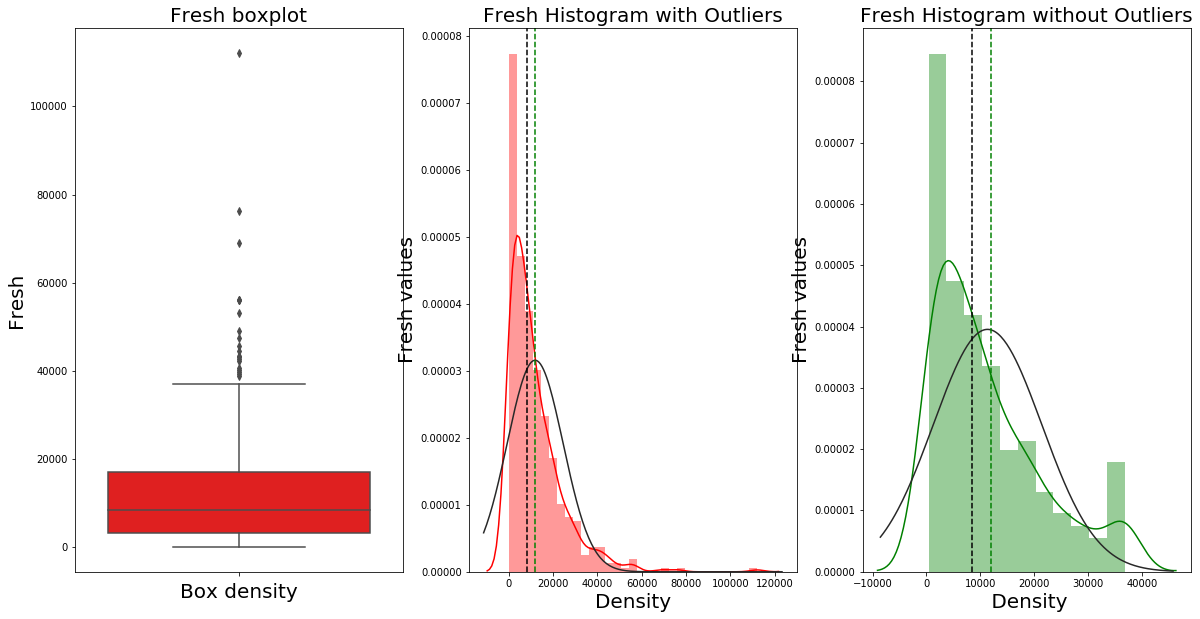

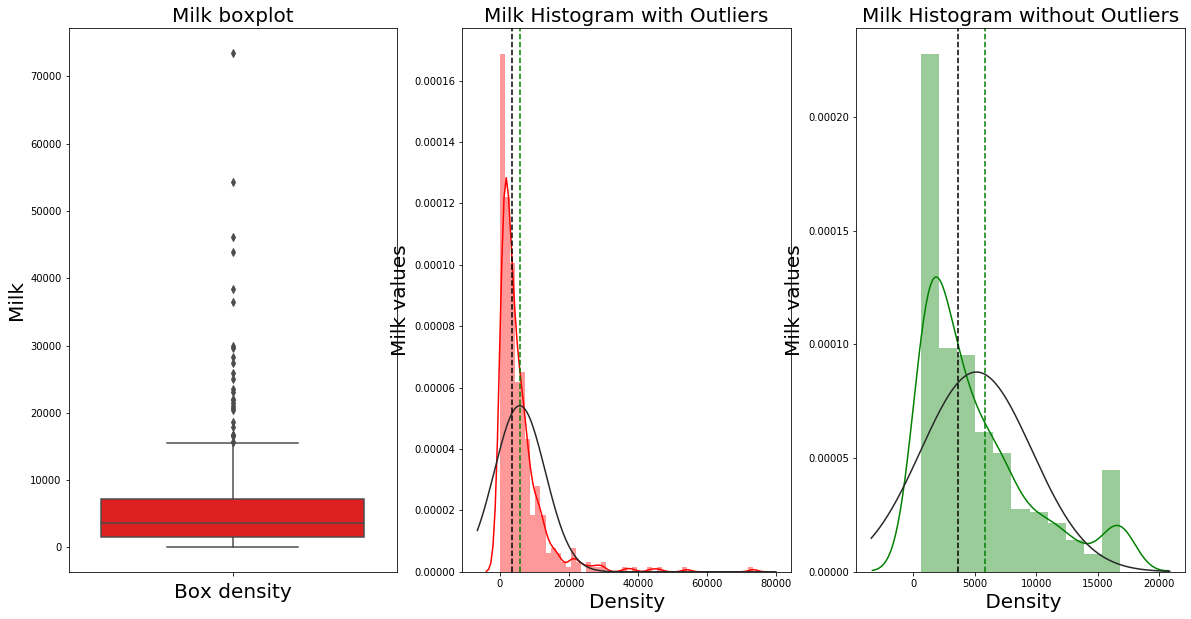

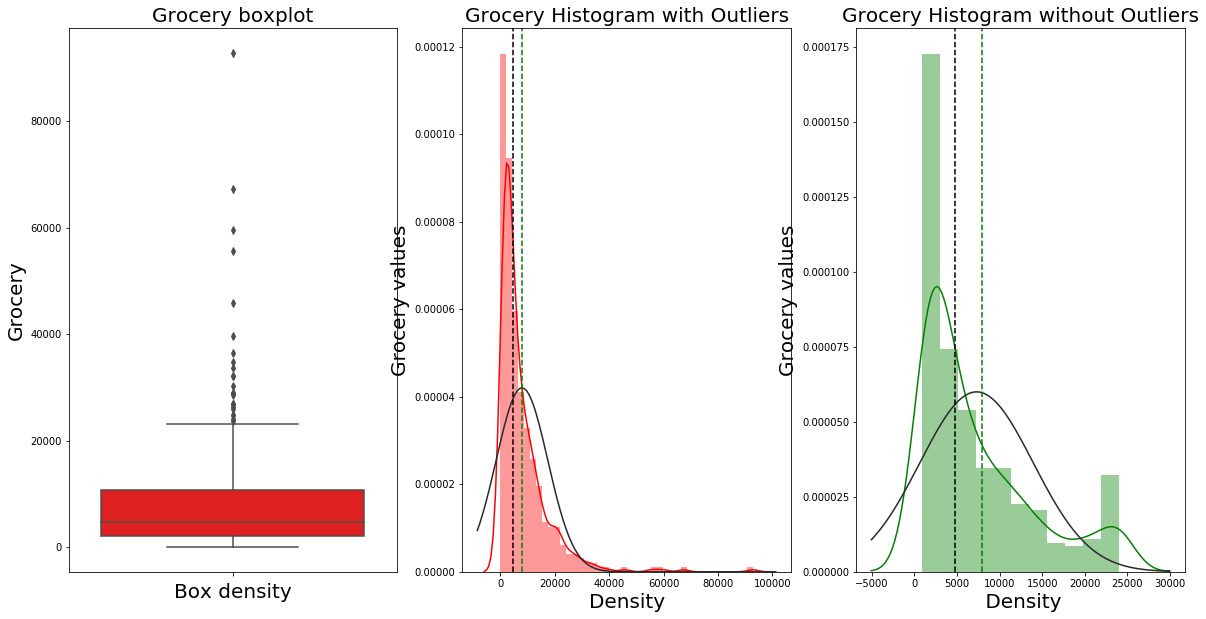

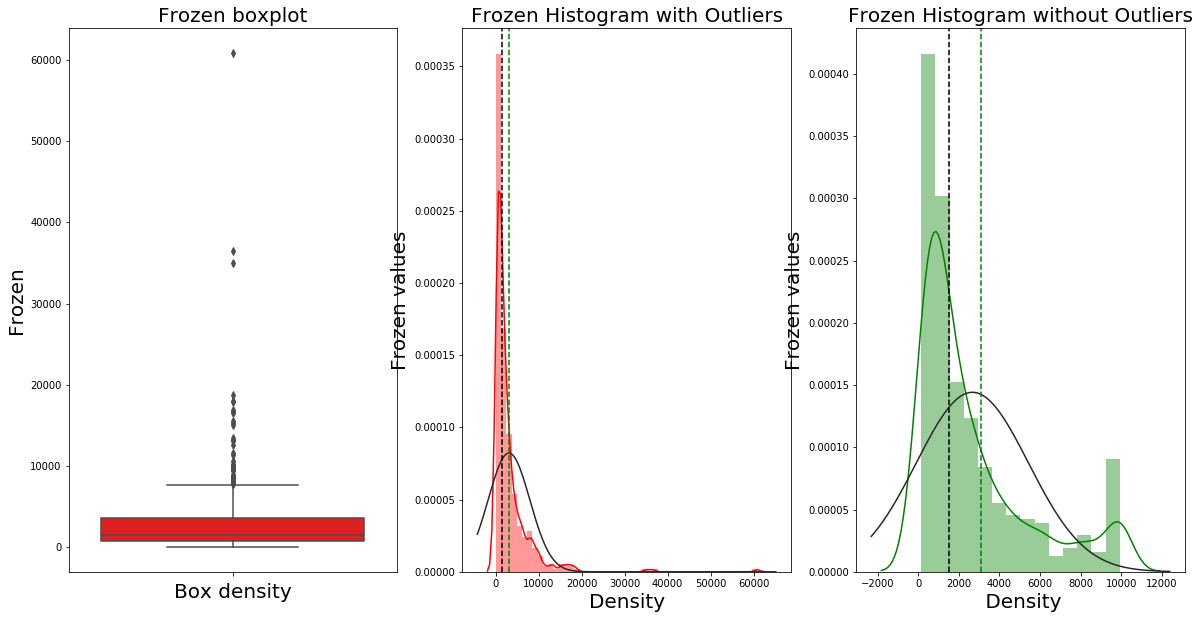

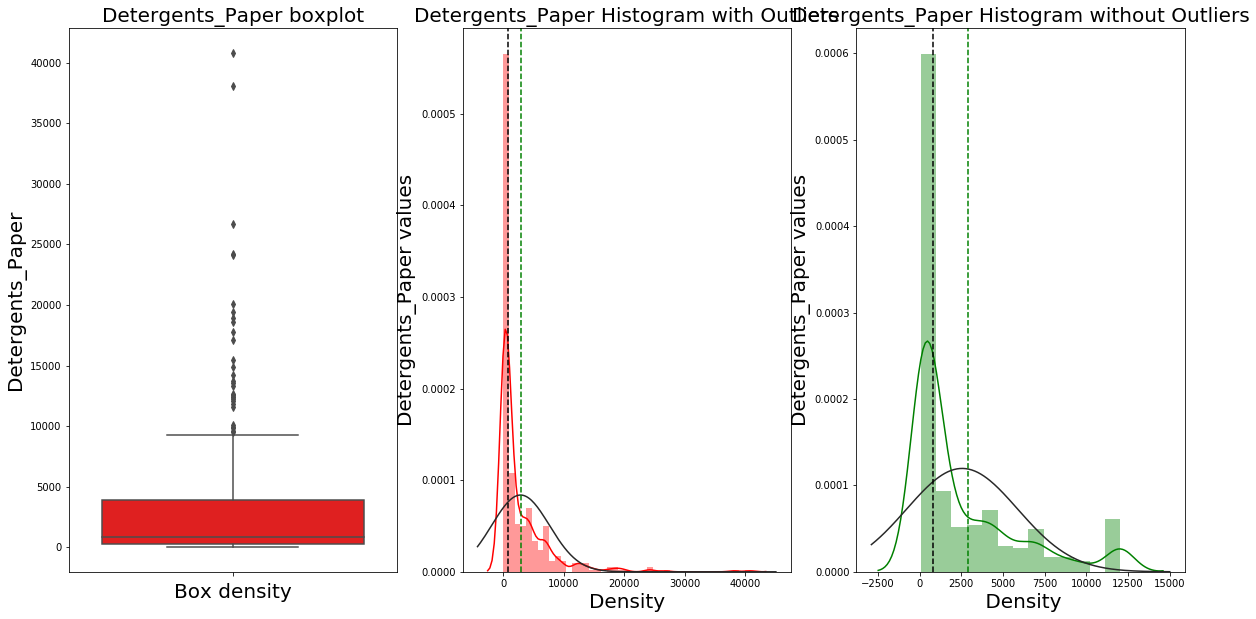

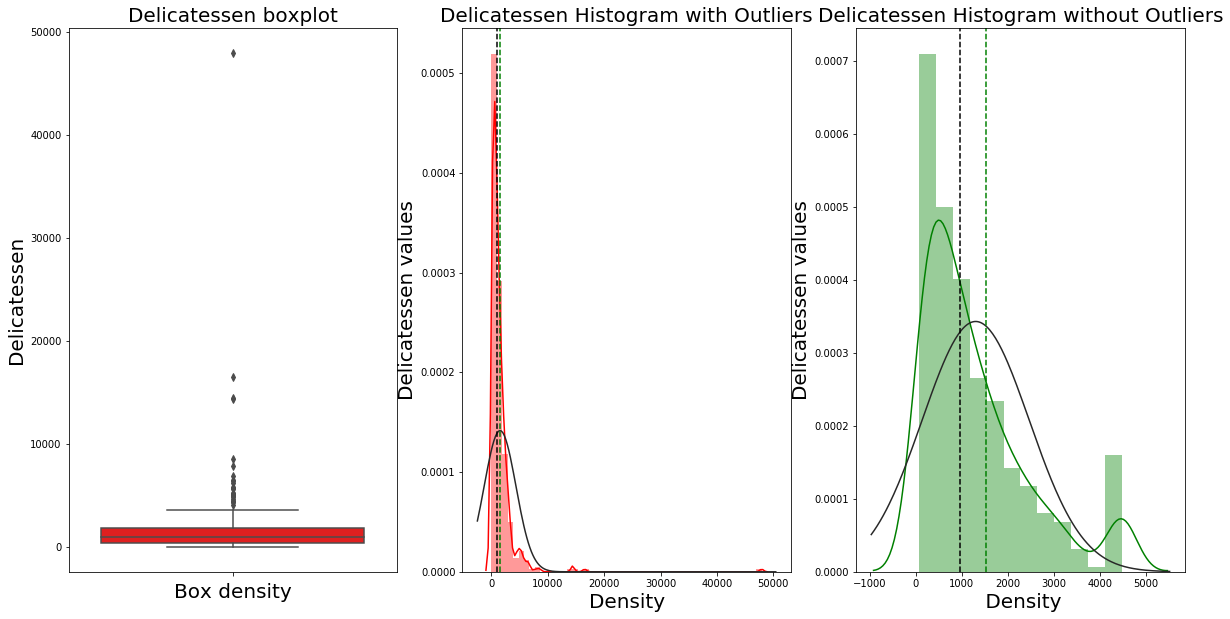

In [23]:
for col in list(df_copy.columns):
    Outlierdetectionplots(df_copy,col)

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

In [24]:
## 1. Assign a copy of the data to log_data after applying logarithmic scaling. Use the np.log function for this.
log_data = df_copy.copy()
log_data = np.log(log_data)
log_data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


In [25]:
## 2. Assign a copy of the sample data to log_samples after applying logarithmic scaling. Again, use np.log.
log_samples = log_data.copy()
log_samples= np.log(log_samples)
log_samples = log_data.sample(n=100, random_state=1)
log_samples.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
283,10.156850,8.192294,7.607381,9.240190,5.749393,7.232733
369,8.734077,5.820083,6.526495,6.993015,3.713572,5.690359
207,7.840313,8.463159,8.714239,7.988204,8.578476,4.787492
300,9.707959,8.739216,8.757784,6.714171,7.886833,7.603399
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446


In [26]:
custom_summary(df_copy)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,440,int64,12000.30,12647.33,1.599549e+08,3,3127.75,8504.0,16933.75,112151,112148.0,13806.00,11.54,2.56,Highly Positively Skewed,Has Outlier
1,Milk,440,int64,5796.27,7380.38,5.446997e+07,55,1533.00,3627.0,7190.25,73498,73443.0,5657.25,24.67,4.05,Highly Positively Skewed,Has Outlier
2,Grocery,440,int64,7951.28,9503.16,9.031010e+07,3,2153.00,4755.5,10655.75,92780,92777.0,8502.75,20.91,3.59,Highly Positively Skewed,Has Outlier
3,Frozen,440,int64,3071.93,4854.67,2.356785e+07,25,742.25,1526.0,3554.25,60869,60844.0,2812.00,54.69,5.91,Highly Positively Skewed,Has Outlier
4,Detergents_Paper,440,int64,2881.49,4767.85,2.273244e+07,3,256.75,816.5,3922.00,40827,40824.0,3665.25,19.01,3.63,Highly Positively Skewed,Has Outlier
5,Delicatessen,440,int64,1524.87,2820.11,7.952998e+06,3,408.25,965.5,1820.25,47943,47940.0,1412.00,170.69,11.15,Highly Positively Skewed,Has Outlier


In [27]:
custom_summary(log_data)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,440,float64,8.73,1.48,2.19,1.10,8.05,9.05,9.74,11.63,10.53,1.69,4.44,-1.63,Highly Negatively Skewed,Has Outlier
1,Milk,440,float64,8.12,1.08,1.17,4.01,7.33,8.20,8.88,11.21,7.20,1.55,0.22,-0.23,Fairly Symmetric(Negative),Has Outlier
2,Grocery,440,float64,8.44,1.12,1.25,1.10,7.67,8.47,9.27,11.44,10.34,1.60,3.70,-0.74,Moderately Negatively skewed,Has Outlier
3,Frozen,440,float64,7.30,1.28,1.65,3.22,6.61,7.33,8.18,11.02,7.80,1.57,0.29,-0.36,Fairly Symmetric(Negative),Has Outlier
4,Detergents_Paper,440,float64,6.79,1.72,2.96,1.10,5.55,6.71,8.27,10.62,9.52,2.72,-0.19,-0.27,Fairly Symmetric(Negative),Has Outlier
5,Delicatessen,440,float64,6.67,1.31,1.72,1.10,6.01,6.87,7.51,10.78,9.68,1.50,3.16,-1.18,Highly Negatively Skewed,Has Outlier


In [28]:
custom_summary(log_samples)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,100,float64,8.60,1.68,2.81,1.10,8.02,8.97,9.63,11.14,10.04,1.61,4.54,-1.79,Highly Negatively Skewed,Has Outlier
1,Milk,100,float64,8.15,1.05,1.09,5.30,7.48,8.23,8.74,10.90,5.60,1.26,0.24,-0.07,Fairly Symmetric(Negative),Has Outlier
2,Grocery,100,float64,8.48,1.09,1.19,5.50,7.68,8.49,9.27,11.44,5.94,1.59,-0.13,0.09,Fairly Symmetric(Positive),No Outlier
3,Frozen,100,float64,7.40,1.17,1.36,3.58,6.73,7.43,8.19,9.74,6.16,1.46,1.06,-0.67,Moderately Negatively skewed,Has Outlier
4,Detergents_Paper,100,float64,6.83,1.79,3.19,1.61,5.56,6.71,8.34,10.62,9.01,2.78,-0.29,-0.18,Fairly Symmetric(Negative),No Outlier
5,Delicatessen,100,float64,6.80,1.03,1.07,4.13,6.22,6.85,7.52,8.77,4.64,1.30,-0.16,-0.31,Fairly Symmetric(Negative),Has Outlier


### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

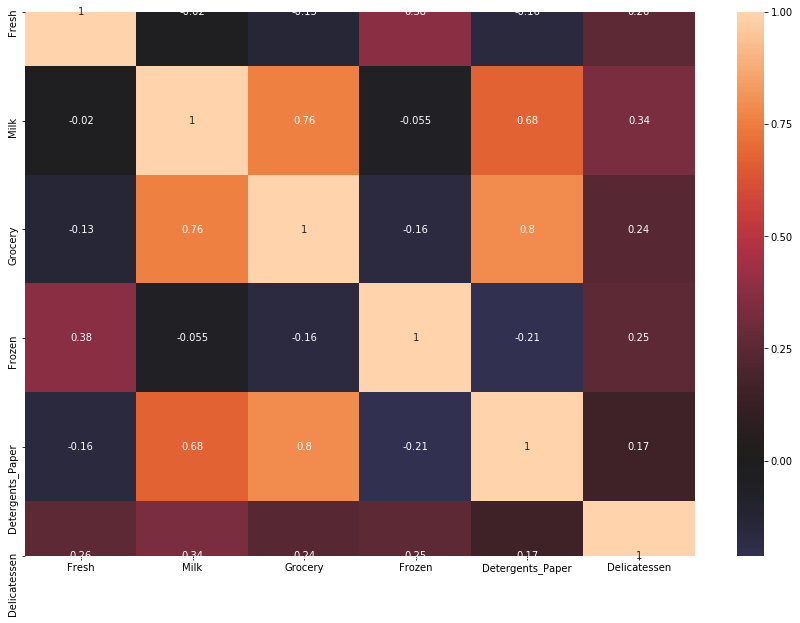

In [29]:
## Checking the correlation if the high correlation between some of the features present earlier still persists or not
corr_matrix= log_data.corr()
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix,center = 0,annot=True)

In [30]:
## We can observe from the heatmap above that, even after log transformation the correlation still exists between the features like
## 1.There is high co-relation between detergents_paper and Grocery.
## 2. There is highcorrelation between milk and grocery
## 3. There is also considerably high correlation between Detergets_Paper and Milk.

In [31]:
# Display the log-transformed sample data
log_samples.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
283,10.156850,8.192294,7.607381,9.240190,5.749393,7.232733
369,8.734077,5.820083,6.526495,6.993015,3.713572,5.690359
207,7.840313,8.463159,8.714239,7.988204,8.578476,4.787492
300,9.707959,8.739216,8.757784,6.714171,7.886833,7.603399
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446


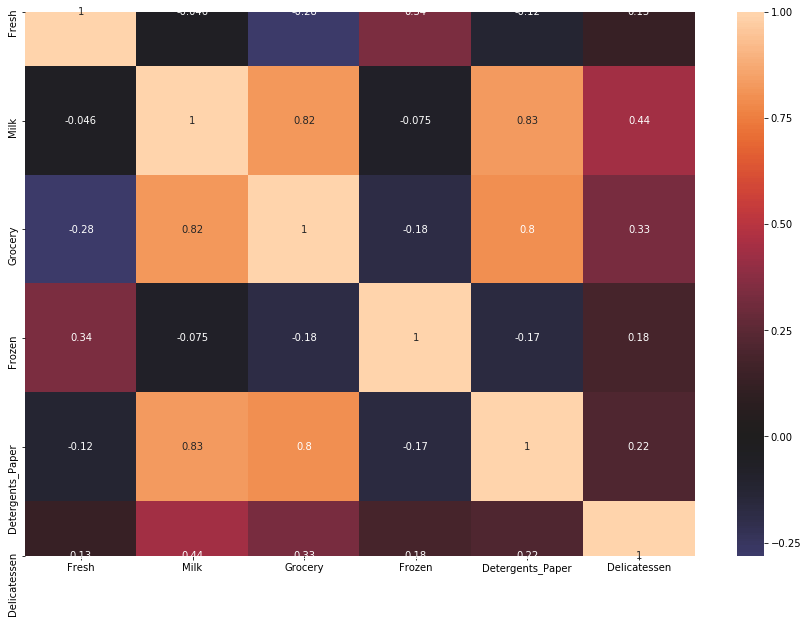

In [32]:
corr_matrix= log_samples.corr()
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix,center = 0,annot=True)

In [33]:
custom_summary(df_copy)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,440,int64,12000.30,12647.33,1.599549e+08,3,3127.75,8504.0,16933.75,112151,112148.0,13806.00,11.54,2.56,Highly Positively Skewed,Has Outlier
1,Milk,440,int64,5796.27,7380.38,5.446997e+07,55,1533.00,3627.0,7190.25,73498,73443.0,5657.25,24.67,4.05,Highly Positively Skewed,Has Outlier
2,Grocery,440,int64,7951.28,9503.16,9.031010e+07,3,2153.00,4755.5,10655.75,92780,92777.0,8502.75,20.91,3.59,Highly Positively Skewed,Has Outlier
3,Frozen,440,int64,3071.93,4854.67,2.356785e+07,25,742.25,1526.0,3554.25,60869,60844.0,2812.00,54.69,5.91,Highly Positively Skewed,Has Outlier
4,Detergents_Paper,440,int64,2881.49,4767.85,2.273244e+07,3,256.75,816.5,3922.00,40827,40824.0,3665.25,19.01,3.63,Highly Positively Skewed,Has Outlier
5,Delicatessen,440,int64,1524.87,2820.11,7.952998e+06,3,408.25,965.5,1820.25,47943,47940.0,1412.00,170.69,11.15,Highly Positively Skewed,Has Outlier


In [34]:
custom_summary(log_data)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,440,float64,8.73,1.48,2.19,1.10,8.05,9.05,9.74,11.63,10.53,1.69,4.44,-1.63,Highly Negatively Skewed,Has Outlier
1,Milk,440,float64,8.12,1.08,1.17,4.01,7.33,8.20,8.88,11.21,7.20,1.55,0.22,-0.23,Fairly Symmetric(Negative),Has Outlier
2,Grocery,440,float64,8.44,1.12,1.25,1.10,7.67,8.47,9.27,11.44,10.34,1.60,3.70,-0.74,Moderately Negatively skewed,Has Outlier
3,Frozen,440,float64,7.30,1.28,1.65,3.22,6.61,7.33,8.18,11.02,7.80,1.57,0.29,-0.36,Fairly Symmetric(Negative),Has Outlier
4,Detergents_Paper,440,float64,6.79,1.72,2.96,1.10,5.55,6.71,8.27,10.62,9.52,2.72,-0.19,-0.27,Fairly Symmetric(Negative),Has Outlier
5,Delicatessen,440,float64,6.67,1.31,1.72,1.10,6.01,6.87,7.51,10.78,9.68,1.50,3.16,-1.18,Highly Negatively Skewed,Has Outlier


In [35]:
custom_summary(log_samples)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,100,float64,8.60,1.68,2.81,1.10,8.02,8.97,9.63,11.14,10.04,1.61,4.54,-1.79,Highly Negatively Skewed,Has Outlier
1,Milk,100,float64,8.15,1.05,1.09,5.30,7.48,8.23,8.74,10.90,5.60,1.26,0.24,-0.07,Fairly Symmetric(Negative),Has Outlier
2,Grocery,100,float64,8.48,1.09,1.19,5.50,7.68,8.49,9.27,11.44,5.94,1.59,-0.13,0.09,Fairly Symmetric(Positive),No Outlier
3,Frozen,100,float64,7.40,1.17,1.36,3.58,6.73,7.43,8.19,9.74,6.16,1.46,1.06,-0.67,Moderately Negatively skewed,Has Outlier
4,Detergents_Paper,100,float64,6.83,1.79,3.19,1.61,5.56,6.71,8.34,10.62,9.01,2.78,-0.29,-0.18,Fairly Symmetric(Negative),No Outlier
5,Delicatessen,100,float64,6.80,1.03,1.07,4.13,6.22,6.85,7.52,8.77,4.64,1.30,-0.16,-0.31,Fairly Symmetric(Negative),Has Outlier


In [36]:
## The correlation in the sample after transforming the data using the logarithmic scale has not resulted in much of a change but the 
## log transformation of data has made the data appear much normal than the previous.
## The custom summary description above shows how the highly positively skews data of most of the features has changed to Fairly symmetric(Negative)
## Skew. Also it can be observed that a highly leptokurtic distribution in the original data has been transformed into Mesokurtic distritutions.

In [37]:
#fig,ax = plt.subplots(figsize=(13,8))
#sns.heatmap(corr_matrix,center = 0,annot=True)

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [38]:
## Removing Outliers by filtering all the data points falling within 1.5 times the IQR(Q1-Q3).
def ReplaceOutliers(df,col,method = 'Quantile',strategy = 'median'):
    col_data = df[col]
    if method == 'Quantile':
        col_mean,col_Q2,col_Q1,col_Q3 = df[col].mean(),df[col].median(),df[col].quantile(0.25),df[col].quantile(0.75)
        IQR = col_Q3-col_Q1
        lowerlim,upperlim = (col_Q1 - 1.5*IQR),(col_Q3 + 1.5*IQR)
        print(f'Outlier for {col} are:',np.sort([x for x in df[col]if x<lowerlim or x>upperlim]),'\n')
        
        ## print outliars 
        outliers = df.loc[(col_data < lowerlim)|(col_data > upperlim),col]
        outlier_density = round(len(outliers)/len(df)*100, 2)
        if len(outliers) == 0:
            print(f'features\'{col}\'does not have any outlier')
        else:
            print(f"total number of outliers are:{len(outliers)}\n")
            print(f"outliers % density:{outlier_density}%\n")
            print(f'outliers for \'{col}\'are :\n{np.sort(np.array(outliers))}\n')
            display(df[(col_data < lowerlim)|(col_data > upperlim)])
        

        # Replacing outliers with mean or median
        strategy = 'median'
        if strategy == 'median':
            df.loc[(df[col] < lowerlim) | (df[col] > upperlim),col] = col_Q2
        else:
            df.loc[(df[col] < lowerlim) | (df[col] > upperlim),col] = col_mean()
    else:
        print('Error')
    return df

In [39]:
for col in list(log_samples.columns):
        good_data= ReplaceOutliers(log_samples,col,method = 'Quantile',strategy = 'median')

Outlier for Fresh are: [1.09861229 2.89037176 4.44265126 4.57471098 4.76217393 5.29831737
 5.38907173] 

total number of outliers are:7

outliers % density:7.0%

outliers for 'Fresh'are :
[1.09861229 2.89037176 4.44265126 4.57471098 4.76217393 5.29831737
 5.38907173]



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
412,4.574711,8.190077,9.425452,4.584967,7.996317,4.127134
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
353,4.762174,8.742574,9.961898,5.429346,9.069007,7.013016


Outlier for Milk are: [ 5.30330491 10.74067014 10.90152416] 

total number of outliers are:3

outliers % density:3.0%

outliers for 'Milk'are :
[ 5.30330491 10.74067014 10.90152416]



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
47,10.702480,10.901524,10.925417,8.959569,10.092909,8.774158
122,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932
85,9.687630,10.740670,11.437986,6.933423,10.617099,7.987524


Outlier for Grocery are: [] 

features'Grocery'does not have any outlier
Outlier for Frozen are: [3.58351894 3.8501476 ] 

total number of outliers are:2

outliers % density:2.0%

outliers for 'Frozen'are :
[3.58351894 3.8501476 ]



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
65,8.966036,9.950323,10.732651,3.583519,10.095388,7.260523


Outlier for Detergents_Paper are: [] 

features'Detergents_Paper'does not have any outlier
Outlier for Delicatessen are: [4.12713439 4.24849524] 

total number of outliers are:2

outliers % density:2.0%

outliers for 'Delicatessen'are :
[4.12713439 4.24849524]



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
412,8.966036,8.190077,9.425452,4.584967,7.996317,4.127134
375,8.672657,7.279319,7.057898,6.391917,6.165418,4.248495


In [40]:
custom_summary(log_samples)

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,100,float64,8.94,1.05,1.11,5.66,8.46,8.97,9.63,11.14,5.48,1.17,0.49,-0.58,Moderately Negatively skewed,Has Outlier
1,Milk,100,float64,8.13,0.93,0.87,5.81,7.55,8.23,8.74,10.16,4.35,1.19,-0.22,-0.21,Fairly Symmetric(Negative),No Outlier
2,Grocery,100,float64,8.48,1.09,1.19,5.50,7.68,8.49,9.27,11.44,5.94,1.59,-0.13,0.09,Fairly Symmetric(Positive),No Outlier
3,Frozen,100,float64,7.47,1.04,1.08,4.58,6.82,7.43,8.19,9.74,5.16,1.37,0.15,-0.25,Fairly Symmetric(Negative),No Outlier
4,Detergents_Paper,100,float64,6.83,1.79,3.19,1.61,5.56,6.71,8.34,10.62,9.01,2.78,-0.29,-0.18,Fairly Symmetric(Negative),No Outlier
5,Delicatessen,100,float64,6.85,0.96,0.93,4.76,6.28,6.86,7.52,8.77,4.01,1.24,-0.35,-0.14,Fairly Symmetric(Negative),No Outlier


In [41]:
#print(df_copy.shape)
#print(good_data.shape)
custom_summary(good_data)
#good_data.head()

,FeatureName,count,Datatype,Mean,SD,Variance,Min,Q1,Median,Q3,Max,Range,IQR,Kurtosis,Skewness,Skewness Comment,Outlier comment
0,Fresh,100,float64,8.94,1.05,1.11,5.66,8.46,8.97,9.63,11.14,5.48,1.17,0.49,-0.58,Moderately Negatively skewed,Has Outlier
1,Milk,100,float64,8.13,0.93,0.87,5.81,7.55,8.23,8.74,10.16,4.35,1.19,-0.22,-0.21,Fairly Symmetric(Negative),No Outlier
2,Grocery,100,float64,8.48,1.09,1.19,5.50,7.68,8.49,9.27,11.44,5.94,1.59,-0.13,0.09,Fairly Symmetric(Positive),No Outlier
3,Frozen,100,float64,7.47,1.04,1.08,4.58,6.82,7.43,8.19,9.74,5.16,1.37,0.15,-0.25,Fairly Symmetric(Negative),No Outlier
4,Detergents_Paper,100,float64,6.83,1.79,3.19,1.61,5.56,6.71,8.34,10.62,9.01,2.78,-0.29,-0.18,Fairly Symmetric(Negative),No Outlier
5,Delicatessen,100,float64,6.85,0.96,0.93,4.76,6.28,6.86,7.52,8.77,4.01,1.24,-0.35,-0.14,Fairly Symmetric(Negative),No Outlier


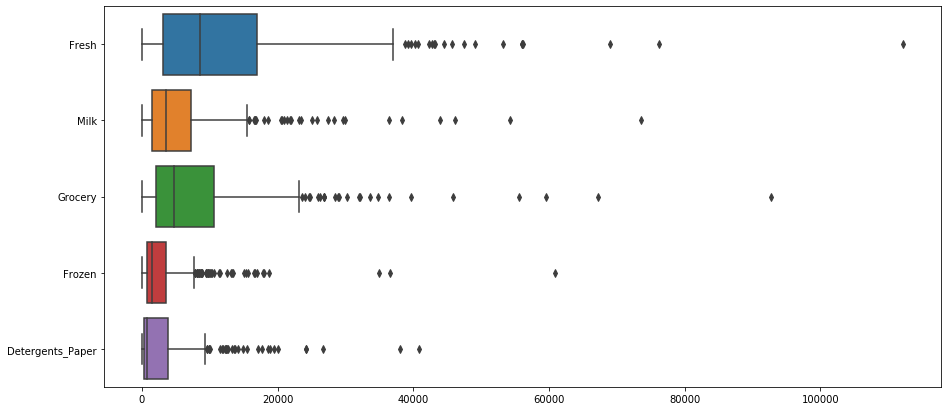

In [42]:
### Visualising the data with outliers
fig = plt.figure(figsize=(15,7))
ax = sns.boxplot(data=df_copy.iloc[:,0:-1],orient='h')

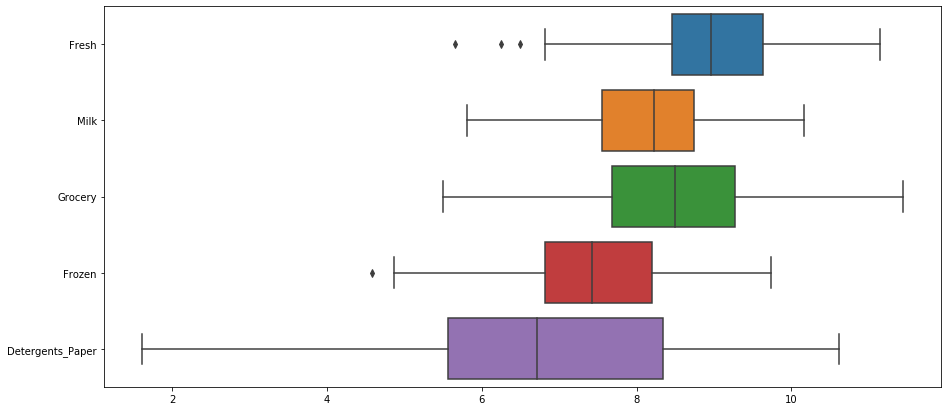

In [43]:
## Visualising the data without outliers
fig = plt.figure(figsize=(15,7))
ax = sns.boxplot(data=good_data.iloc[:,0:-1],orient='h')

In [44]:
### The outliers have been removed by filtering out the datapoints falling outside 1.5 times the IQR.

### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

In [45]:
## Yes,after filtering the dataset based on 1.5 times the IQR,
## outliers have been identified and replaced with the median values and stored in a variable called good_data.
## The datapoints as outliers were removed and replaced with the median value.
## Presence of outliers do play a role in K-means clustering  since each observation belongs to the 
## cluster with the nearest mean and presence of outliers has an impact on that mean.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [46]:
## Implement PCA for the above data
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca_samples = pca.fit_transform(log_samples)
pca_samples = pd.DataFrame(pca_samples, columns=['pc1', 'pc2', 'pc3', 'pc4','pc5','pc6'])
pca_samples.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,-1.383981,-2.070244,-0.004978,0.501115,-0.427686,-0.241054
1,-4.314091,1.079641,-0.448216,-0.213961,0.251367,0.605726
2,1.300251,1.292372,-1.127411,2.054816,-0.276009,-0.162969
3,1.339766,-0.392440,-0.226088,-1.091148,-0.330759,0.047845
4,-2.131315,-0.465168,1.174050,-0.885093,0.557883,-0.096964


### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

In [47]:
pca.explained_variance_ratio_

array([0.56754309, 0.18945236, 0.08923975, 0.08653975, 0.03671251,
       0.03051254])

In [48]:
np.cumsum(pca.explained_variance_ratio_)

array([0.56754309, 0.75699545, 0.8462352 , 0.93277495, 0.96948746,
       1.        ])

In [64]:
## How much variance in the data is explained* **in total** *by the first and second principal component? 
## In total, the first and 2nd PCA is showing a variance from 0.59 to 0.76 respectively.
## How much variance in the data is explained by the first four principal components?
## The first four PCA shows a variance ranging from 0.596 to 0.169 to 0.089 to 0.073
## It can be observed that a major portion of the overall variance is contained in the first four PCA(i.e.PC1,PC2,PC3,PC4)

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [50]:
pca_samples.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,-1.383981,-2.070244,-0.004978,0.501115,-0.427686,-0.241054
1,-4.314091,1.079641,-0.448216,-0.213961,0.251367,0.605726
2,1.300251,1.292372,-1.127411,2.054816,-0.276009,-0.162969
3,1.339766,-0.392440,-0.226088,-1.091148,-0.330759,0.047845
4,-2.131315,-0.465168,1.174050,-0.885093,0.557883,-0.096964


In [51]:
log_samples.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
283,10.156850,8.192294,7.607381,9.240190,5.749393,7.232733
369,8.734077,5.820083,6.526495,6.993015,3.713572,5.690359
207,7.840313,8.463159,8.714239,7.988204,8.578476,4.787492
300,9.707959,8.739216,8.757784,6.714171,7.886833,7.603399
429,9.060331,7.467371,8.183118,7.426228,4.430817,7.824446


In [52]:
# Display sample log-data after having a PCA transformation applied
# display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

In [53]:
#display(pd.DataFrame(np.round(pca_samples, 4)))

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [54]:
# from sklearn.preprocessing import StandardScaler
# x1 = StandardScaler().fit_transform(df_pca) 
# columns=[]
# from sklearn.decomposition import PCA
# pca3 = PCA(n_components=2)
# principal_components = pca3.fit_transform(x1)
# reduced_data = pd.DataFrame(principal_components)
# reduced_data.head()

In [55]:
# from sklearn.preprocessing import StandardScaler
# x2 = StandardScaler().fit_transform(log_samples) 
# columns=[]
# from sklearn.decomposition import PCA
# pca3 = PCA(n_components=2)
# principal_components = pca3.fit_transform(x1)
# pca_samples = pd.DataFrame(principal_components)
# pca_samples.head()

In [56]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(good_data)
pca_samples = pca.fit_transform(log_samples)

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [57]:
reduced_data

array([[-1.38398079, -2.07024429],
       [-4.31409075,  1.07964087],
       [ 1.30025058,  1.29237223],
       [ 1.33976577, -0.39243991],
       [-2.13131454, -0.46516835],
       [-0.31376375, -0.38114848],
       [ 3.82349024, -2.85908596],
       [-2.09057864,  0.54369837],
       [-1.2582914 , -0.10050626],
       [ 1.01588349, -1.96362006],
       [-1.73437691, -0.2021793 ],
       [ 1.09863396, -1.75885185],
       [ 2.24226766, -1.0763139 ],
       [-1.04811147, -0.40150288],
       [ 3.48315628, -0.41503843],
       [ 2.90528389, -0.21988059],
       [-4.22519803, -0.39879224],
       [-0.54948835,  0.92185044],
       [ 1.6365491 ,  1.76456216],
       [-1.80358305, -1.94289822],
       [ 2.75716727, -0.54559172],
       [ 1.02226214,  0.21140232],
       [ 1.16451652, -0.90347063],
       [ 2.83424759,  3.22510479],
       [-0.15657738,  1.29935578],
       [-1.58027084,  1.80159381],
       [-0.41410711, -0.10475528],
       [-1.72904262,  0.73145964],
       [-1.53115134,

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

In [58]:
## Advantagesof Kmeans clustering algorithm
## Can easily scale to large data sets
## Gaurantees convergence
## Generalises to clusters of different shapes and sizes
## The positions of the centroids can be maintained

## Advantages of Gaussian mixture model clustering algorithm
## GMM is a lot more flexible in terms of cluster covariance
## GMM model accommodates mixed membership
## if you think that your model is having some hidden, not observable parameters, then you should use GMM.
## GMM produces non-convex clusters, which can be controlled with the variance of the distribution. 


### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [59]:
# labels = KMeans(n_clusters=2, random_state=100).fit_predict(reduced_data)
# sns.scatterplot(reduced_data.iloc[:,0],reduced_data.iloc[:,1],hue=labels)

In [60]:
# ## Finding clusters form every variable with all other variables
# def kmeansplot(x,t_col,labels):
#     #x=new_concrete.copy()
#     #t_col='strength'

#     columns = list(set(reduced_data.iloc[:,0])-set(reduced_data.iloc[:,1]))
#     r = int(len(columns)/2) 
#     if r%2 == 0:
#         r = r
#     else:
#         r = r+1
#     f,ax=plt.subplots(r,2,figsize=(15,15))
#     a = 0
#     for col in range (0,r): #This for loop for all the rows
#         for j in range (0,2): # This for loop is for the columns
#             if a != len(columns):
#                 ax[col][j].scatter(x[t_col],x[columns[a]],c=labels)
#                 ax[col][j].set_xlabel(t_col)
#                 ax[col][j].set_ylabel(columns[a])
#                 a = a+1

In [61]:
# x = reduced_data.iloc[:,0]
# x=pd.DataFrame(x)
# y = reduced_data.iloc[:,1]
# y=pd.DataFrame(y)

# for col in x.columns:
#     kmeansplot(reduced_data,col,labels)

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
clusterer = KMeans(n_clusters=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
sample_preds = clusterer.predict(pca_samples)
score=silhouette_score(reduced_data,preds)
print(score)

0.48925931676845585


### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

In [65]:
## for n=2, the silhoutte score was found to be 0.489259
## for n=3, the silhoutte score was found to be 0.44477
## for n=4, the silhoutte score was found to be 0.33842
## for n=5, the silhoutte score was found to be 0.40450
## for n=6, the silhoutte score was found to be 0.37381
## for n=7, the silhoutte score was found to be 0.35400

## The best silhoute score is achieved at n=2.
##reduced_data.head()

In [73]:
reduced_data=pd.DataFrame(reduced_data)
reduced_data=reduced_data.rename(columns={0:"PC1",1:"PC2"})
reduced_data.head()

,PC1,PC2
0,-1.383981,-2.070244
1,-4.314091,1.079641
2,1.300251,1.292372
3,1.339766,-0.392440
4,-2.131315,-0.465168


### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

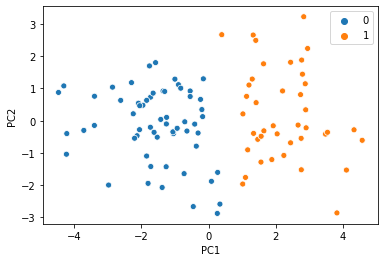

In [74]:
labels = KMeans(n_clusters=2, random_state=100).fit_predict(reduced_data)
sns.scatterplot(reduced_data.iloc[:,0],reduced_data.iloc[:,1],hue=labels)

### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

In [80]:
## Considering the original dataset that was used in the beginning
## Comparing the reference mean given above with the mean of the data set
print("The reference mean values are shown below")
print("Reference Mean values")
print("---------------------")
print("Fresh:      12000.2977")
print("Milk:        5796.2")
print("Grocery:     3071.9")
print("---------------------")

The reference mean values are shown below
Reference Mean values
---------------------
Fresh:      12000.2977
Milk:        5796.2
Grocery:     3071.9
---------------------


In [82]:
## Adding features based on clusters
new_df = df_copy.join(pd.DataFrame(labels,columns=['labels']),how='left')
new_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,labels
0,12669,9656,7561,214,2674,1338,0.0
1,7057,9810,9568,1762,3293,1776,0.0
2,6353,8808,7684,2405,3516,7844,1.0
3,13265,1196,4221,6404,507,1788,1.0
4,22615,5410,7198,3915,1777,5185,0.0


In [88]:
## Grouping the segments based on clusters and finding the mean and median for the same
newfeat = new_df.groupby('labels')['Fresh'].agg(['mean','median'])
newfeat1 = new_df.groupby('labels')['Milk'].agg(['mean','median'])
newfeat2 = new_df.groupby('labels')['Grocery'].agg(['mean','median'])
newfeat3 = new_df.groupby('labels')['Frozen'].agg(['mean','median'])
newfeat4 = new_df.groupby('labels')['Detergents_Paper'].agg(['mean','median'])
newfeat5 = new_df.groupby('labels')['Delicatessen'].agg(['mean','median'])

In [97]:
print("For Fresh",newfeat)
print("For Milk",newfeat1)
print("For Grocery",newfeat2)
print("--------------------------------------")
print("Comparing the mean values of the clustered segments above with the reference mean values")
print("The reference mean values are shown below")
print("Reference Mean values")
print("---------------------")
print("Fresh:      12000.2977")
print("Milk:        5796.2")
print("Grocery:     3071.9")
print("---------------------")

For Fresh                 mean  median
labels                      
0.0     11489.779661    9198
1.0     15069.512195   12754
For Milk                mean  median
labels                     
0.0     8747.813559    5332
1.0     7721.634146    3259
For Grocery                 mean  median
labels                      
0.0     11596.152542    7854
1.0     10510.926829    5956
--------------------------------------
Comparing the mean values of the clustered segments above with the reference mean values
The reference mean values are shown below
Reference Mean values
---------------------
Fresh:      12000.2977
Milk:        5796.2
Grocery:     3071.9
---------------------


In [98]:
## By comparing the mean values above with the reference mean values given in the question, 
## I can observe that 
## for the segment 1 or the 1st cluster, 
## I can conclude that the amount spent on Fresh is almost the same as the reference mean but the amount spent on
## Milk and Grocery is much more than the reference value mean, therefore segement 1 or label 0.0 is " Restaurant" establishment
## for the segment 2 or the 2nd cluster,
## I can conclude that the amount spent on Fresh is much more than the reference mean and also the amount spent on
## Milk and Grocery is much more than the reference value mean, therefore segement 2 or label 1.0 is " Supermarket" establishment

### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [111]:
print(sample)
print("--------------------------")
print(new_df.iloc[193,:])
print("--------------------------")
print(new_df.iloc[39,:])
print("--------------------------")
print(new_df.iloc[262,:])
print("--------------------------")

     Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
193    180  3485    20292     959              5618           666
39   56159   555      902   10002               212          2916
262  23257  1372     1677     982               429           655
--------------------------
Fresh                 180.0
Milk                 3485.0
Grocery             20292.0
Frozen                959.0
Detergents_Paper     5618.0
Delicatessen          666.0
labels                  NaN
mean                    NaN
median                  NaN
Name: 193, dtype: float64
--------------------------
Fresh               56159.000000
Milk                  555.000000
Grocery               902.000000
Frozen              10002.000000
Detergents_Paper      212.000000
Delicatessen         2916.000000
labels                  1.000000
mean                15069.512195
median              12754.000000
Name: 39, dtype: float64
--------------------------
Fresh               23257.0
Milk                 1372.0

In [ ]:
## The 1st sample is of a household as compared to the large establishments as seen in the clusters,therefore it is not labelled
## The 2nd sample is a large establishment either a "Supermarket" or a "large Fresh Veggies" Vendor
## The 3rd sample is also not labelled but it can bee seen as a medium size "Fresh Veggies" vendor

## Conclusion

## The predictions seem to be fairly consistent and due to the irregularity in the data and the outliers being removed we can conclude that the clusters and segment that was created in the datapoints in question 8 is helpful for the analysis of the data since it helps a lot in understanding the kind of establishments that each record belongs to.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

In [ ]:
## A survey can be conducted with all the existing customers to weigh in their opinion and 
## An independent or unpaired sample T-test can be performed on both the segments to know if the difference in opinion
## between the 2 populations is statistically significant or not.
## This decision of delivering 3 days a week affects the small sized establishments more than the large sized ones since the they have 
## smaller inventories and their stock gets over sooner than the large establishments.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

In [ ]:
## A supervised learner like KNN would be ideal to train on the original customers and the model could then be used to predict the product 
## spending and then use the data to the label and segment the customers.
## The Target variable that could be considered ideal for this kind of prediction would be "Fresh" since
## this feature is non colinear and has a greater feature importance compared to any other features.
## Also while performing the R2 score and correlation study we found out that "Fresh" category was one of the most relevant features
## in the dataset.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

In [115]:
df_channel = df.drop("Region",axis=1)
df_channel.head()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,12669,9656,7561,214,2674,1338
1,2,7057,9810,9568,1762,3293,1776
2,2,6353,8808,7684,2405,3516,7844
3,1,13265,1196,4221,6404,507,1788
4,2,22615,5410,7198,3915,1777,5185


In [120]:
pca = PCA(n_components=2)
pca_channel = pca.fit_transform(df_channel)
pca_channeldf = pd.DataFrame(pca_channel)
pca_channeldf = pca_channeldf.rename(columns={0:"PC1",1:"PC2"})
pca_channeldf.head()

,PC1,PC2
0,650.022118,1585.519107
1,-4426.804985,4042.451520
2,-4841.998712,2578.762187
3,990.346443,-6279.806002
4,10657.998730,-2159.725789


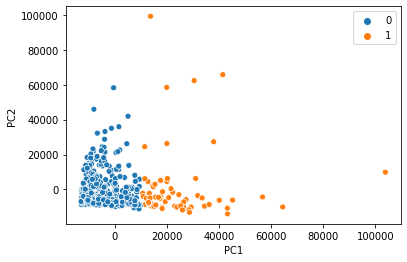

In [121]:
labels = KMeans(n_clusters=2, random_state=100).fit_predict(pca_channeldf)
sns.scatterplot(pca_channeldf.iloc[:,0],pca_channeldf.iloc[:,1],hue=labels)

In [ ]:
## After visualising the clusters forming after running th pca for the data including the channel feature, the structure above 
## shows that cluster "0" is the "HoReCa" and the cluster "1" is the "Retail" chain.

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

In [ ]:
## The clustering algorithm distinctly separates out the HoReCa category of customers from the Retailer customers
## as seen in the visualisation above.
## Yes, this classficication seems more consistent compared to the previous clustering classification since some datapoints can be 
## distinctly classified as purely retailers or HoReCa categories.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.